## NLP homework 1  


> **Data handling and processing**
- > path directiories
- > dataset creation, from .tsv to List of Dicionaries 
- > dictionaries: vocabulary and index for classes

In [1]:
from utils import dataset_creation
import os
from pathlib import Path
from utils import vocabulary_and_lableDictionary
import torch.nn.functional as F
import torch

#to get the current working directory
current_dir = Path(os.getcwd())





'''
Create Dataset for 
Train
'''
main_dir=current_dir.parent.parent.absolute()
dataset_path=os.path.join(main_dir, "data/train.tsv")
data_train=dataset_creation(dataset_path)
vocab,label_dict=vocabulary_and_lableDictionary(data_train)


'''
Create Dataset for 
Test
'''
dataset_path_dev=os.path.join(main_dir, "data/dev.tsv")
data_test=dataset_creation(dataset_path_dev)
print('\nYour path for TRAIN dataset is :',dataset_path)
print('\nYour path for DEV dataset is :',dataset_path_dev)

#print(label_dict)





Your path for TRAIN dataset is : /home/francesco/Desktop/NLP/nlp2022-hw1-main/data/train.tsv

Your path for DEV dataset is : /home/francesco/Desktop/NLP/nlp2022-hw1-main/data/dev.tsv


> **Import data for word2vec**
- > *word2vec* in is version **GoogleNews-vectors-negative300** is 3.6 GB and his processing it takes time
- > using the **pre-trained.ipynb** is possible generate Dictionaries and Weights for word2vec embedding and GLOVE Embedding
- > dictionary and vocabulary are loaded from npy file previously processed, in order to avoid this pre-processing phase each time

In [2]:
import numpy as np



dict_path=os.path.join(main_dir, "hw1/data/Dict_W2W.npy")
weight_path=os.path.join(main_dir, "hw1/data/Weight_W2W.npy")

Dictionary = np.load(dict_path,allow_pickle='TRUE').item()
weight = np.load(weight_path,allow_pickle='TRUE')
weight_tensor=torch.from_numpy(weight)
    


> **Torch and batches**
- > Process "Sentence" and "Labels" List[Dict] structure 
- > Obtain  "x" and "y" List[Dict] structure
- > x is : Words are converted with vocabulary indexes and padded 
- > y is : Tag labels are converted with labels indexes and padded
- > x and y are converted in a tensor form



In [3]:
from torch.nn.utils.rnn import pad_sequence
import torch
from typing import Dict, List

# collate fn
PAD_TOKEN = "<PAD>"
UNK_TOKEN = "<UNK>"



def prepare_batch(batch: List[Dict]) -> List[Dict]:
  # extract features and labels from batch
  x = [sample["sentence"] for sample in batch]
  y = [sample["labels"] for sample in batch]
  # convert words to index
  x = [[Dictionary.get(word, Dictionary[UNK_TOKEN]) for word in sample] for sample in x]
  # convert labels to index
  y = [[label_dict.get(label) for label in sample] for sample in y]
  # convert features to tensor and pad them
  x = pad_sequence(
    [torch.as_tensor(sample) for sample in x],
    batch_first=True,
    padding_value=Dictionary.get(PAD_TOKEN)
  )
  # convert and pad labels too
  y = pad_sequence(
    [torch.as_tensor(sample) for sample in y],
    batch_first=True,
    padding_value=0
  )
  return {"x": x, "y": y}

> Classes for **DataLoader**, **word2vec embedder** and **LSTM_TAGGER**
- > **NERD**ataset is created using torch utilis
- > **word2vec_Embedder** works in 4 different modalities with boolean variables **by_id** and **batch**


**batch** that can be used to spefify if is expecting only a tokenized sentence or a batch ot tokenized senteces

**by_id** to specify if the model should exspect list of tokens or already indexed senteces. 

ie. for bath = False and [0 1 4 58 15 98] with by_id=True and ['the','cat','is','on','the','table']



check commented part in next code box to test it.


In [4]:
from torch.utils.data import DataLoader, Dataset 

#________________________________________________________________________
class NERDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index) -> List[Dict]:
        return self.data[index]
#________________________________________________________________________
class W2W_Embedding():

    def __init__(self, weights, dict, batch, by_id ) -> None:

        self.weights = weights
        self.dict = dict
        self.batch = batch
        self.weights_leng = len(self.weights[0,:])
        self.by_id = by_id
    

    def get_weight(self,token):


        if(self.by_id == False):
            try : index_token = self.dict[token]
            except : 
                #print('missing')
                index_token = self.dict['UNK']
        else:
            return self.weights[token,:]

        
    
        return self.weights[index_token,:]


    def embedd(self,list_words):

        list=[]
        
        if(self.batch == False):

            for word in list_words:
                list.append(self.get_weight(word).tolist())
            

            

            return torch.tensor(list)
        
        elif(self.batch == True):

            max_pad = longest(list_words)
            #print('max padd',max_pad)

            

            for sentence in list_words:

                current_lenght = len(sentence)
                #print('current :',current_lenght)
                sencence=[]
                for word in sentence:
                    sencence.append(self.get_weight(word).tolist())
                
                

                if(max_pad>current_lenght):
                    #print('padding')
                    listofzeros = [0] * self.weights_leng

                    while max_pad>current_lenght:
                        #print('padding now')
                        sencence.append(listofzeros)
                        #print('new leng',len(sencence))
                        current_lenght = len(sencence)
                

                #print('append list',len(sencence))
                list.append(sencence)


            return torch.tensor(list)
#________________________________________________________________________
class LSTMTagger(torch.nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()

        #self.word_embeddings = torch.nn.Embedding(vocab_size, embedding_dim)
        
        #if bidirectional false
        #self.lstm = torch.nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        #self.hidden2tag = torch.nn.Linear(hidden_dim, tagset_size)

        self.lstm_w2w = torch.nn.LSTM(embedding_dim, hidden_dim, batch_first=True,num_layers=2,bidirectional=True,dropout=0.2)
        self.hidden2tag = torch.nn.Linear(2*hidden_dim, hidden_dim)
        self.drop = torch.nn.Dropout(p=0.3)
        self.hidden3tag = torch.nn.Linear(hidden_dim, tagset_size)
        self.soft_max = torch.nn.Softmax(dim=2)


    def forward(self, sentence):


        #embeds = self.word_embeddings(sentence)
        #print('embeds size',embeds.size())
  
        lstm_out, _ = self.lstm_w2w(sentence)
        #print('lstm_out size',lstm_out.size())

        tag_space = self.hidden2tag(lstm_out)
        tag_space = self.drop(tag_space)
        tag_space = self.hidden3tag(tag_space)
        

        #print('tag_space size',tag_space.size())

        #tag_scores=self.soft_max(tag_space)
        #print('tag_scores size',tag_scores.size())

        return tag_space
#________________________________________________________________________





def longest(list1):
    longest_list = max(len(elem) for elem in list1)
    return longest_list




 

> **Training preparation**
- > DataLoader for training set and test set are defined
- > create LSTM_Tagger specifing dimensionaly of expeceted input and hidded space 
- > Commented part present tests over Dataloaders and Glove Embedding



In [5]:
# data loader parameters
collate_fn = prepare_batch # the function that will prepare the data for the model
batch_sizes = 32
num_workers = min(os.cpu_count(), 4)  # it is usually 4 workers per GPU
is_train_dataloader = False # we don"t want to shuffle dev and test data



#NERDdataset for both training and test(from dev.tsv)
train_dataset = NERDataset(data_train)
dev_dataset=NERDataset(data_test)



#DataLoader definition

train_data_loader = DataLoader(
  train_dataset,
  collate_fn=collate_fn,
  shuffle=is_train_dataloader,
  batch_size=batch_sizes,
  num_workers=num_workers,
)



dev_data_loader = DataLoader(
  dev_dataset,
  collate_fn=collate_fn,
  shuffle=is_train_dataloader,
  batch_size=batch_sizes,
  num_workers=num_workers,
)


        
#Create model for Word2vec
embedding_dim=300
hidden_dim=300
vocab_size=len(vocab)
tagset_size=len(label_dict)
modelW2W=LSTMTagger(embedding_dim, hidden_dim, vocab_size, tagset_size)




'''

#Test for data_loaders

i=0
for batch in train_data_loader:
  i+=1
print(' number of Batch in TRAIN :',i)


i=0
for batch in dev_data_loader:
  i+=1
print(' number of Batch in DEV :',i)

'''


'''
# TESTING GLOVE ENBEDDING

lis=[['table','on','book','you','?'],['the','my','cat'],['table','on','book','you']]
#CHECK on longest fucntion,  used for padding in batch mode
print(longest(lis))
            



Ge = GloveEmbedding(weight_tensor,Dictionary,False,False)
#Check on get_weight function
print(Ge.get_weight('robin').size())
#Using BATCH = False
print(Ge.embedd(['the','my','cat']).size())



#Using BATCH = TRUE but passing no index but directly words
Ge = GloveEmbedding(weight_tensor,Dictionary,True,False)
print(Ge.embedd([['the','my','cat'],['table','on','book','you'],['table','on','book','you','?']]).size())

#Using BATCH = TRUE but with passing idexes of words
Ge = GloveEmbedding(weight_tensor,Dictionary,True,True)
print(Ge.embedd([[1,0,3,5],[0,2],[1,4,8,9,2,5]]).size())


#MODIFY TEXT FILE TO ADD PADD OPTION


'''
    







"\n# TESTING GLOVE ENBEDDING\n\nlis=[['table','on','book','you','?'],['the','my','cat'],['table','on','book','you']]\n#CHECK on longest fucntion,  used for padding in batch mode\nprint(longest(lis))\n            \n\n\n\nGe = GloveEmbedding(weight_tensor,Dictionary,False,False)\n#Check on get_weight function\nprint(Ge.get_weight('robin').size())\n#Using BATCH = False\nprint(Ge.embedd(['the','my','cat']).size())\n\n\n\n#Using BATCH = TRUE but passing no index but directly words\nGe = GloveEmbedding(weight_tensor,Dictionary,True,False)\nprint(Ge.embedd([['the','my','cat'],['table','on','book','you'],['table','on','book','you','?']]).size())\n\n#Using BATCH = TRUE but with passing idexes of words\nGe = GloveEmbedding(weight_tensor,Dictionary,True,True)\nprint(Ge.embedd([[1,0,3,5],[0,2],[1,4,8,9,2,5]]).size())\n\n\n#MODIFY TEXT FILE TO ADD PADD OPTION\n\n\n"

> **Model Training W2W model**
- > Loss fucntion
- > Optimizer
- > Glove Embedding modality coherent with dataloader choise, i.e Batch = True and By_id = True
- > Training, Validation after each epochs
- > **Accuracy**, **Loss** and **F1 score ('macro')** are cumulated after each batch, averaged over all batches and stored for each **Epochs**




**note :** .train() .eval() torch.no_grad() used to swich between training and inference modalities

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(modelW2W.parameters(), lr=0.1, momentum=0.9)
Ge = W2W_Embedding(weight_tensor,Dictionary,True,True)


i=0
loss_history = []
loss_history_val = []


f1_history = []
f1_history_val = []

for epoch in range(50):

  count=0
  accuracy_epoch=0
  total_prediction=[]
  total_labels=[]
  running_loss = 0
  modelW2W.train()
  

  for batch in train_data_loader:

    modelW2W.zero_grad()

    batch_x=batch['x']
    batch_y=batch['y']

    #GLOVE EMBEDDING
    batch_x = Ge.embedd(batch_x.tolist())
    #print(batch_x.size())

     
    
    

    prediction=modelW2W.forward(batch_x)

    #print('Predicted: ',prediction.size())
    #print('Ground Truth: ',batch_y.size())
    sizes=prediction.size()
    #print(sizes[0])
    l0=sizes[0]
    l1=sizes[1]
    l2=sizes[2]
    l3=l0*l1

    new_size = (l3,l2)
    prediction_batch = torch.reshape(prediction,new_size)


    
    target_batch = torch.flatten(batch_y)
  

    

    loss = loss_function(prediction_batch,target_batch)
    running_loss += loss.item()
    loss.backward()
    optimizer.step()

    





    pre_accu=torch.argmax(prediction_batch, dim=1)

    #print('predited',pre_accu)
    #print('target',target_batch)


    train_acc = torch.sum(pre_accu == target_batch)

    batch_train_acc = (np.array(train_acc))/(target_batch.size())

    accuracy_epoch=accuracy_epoch+batch_train_acc
    

    
    total_prediction=total_prediction+(pre_accu.tolist())
    total_labels=total_labels+(target_batch.tolist())
    count+=1
  

  running_loss_avg = (running_loss/count)
  loss_history.append(running_loss_avg)
  f1_score_epoch = f1_score(total_labels, total_prediction,average=None)
  f1_score_epoch_macro = f1_score(total_labels, total_prediction,average='macro')
  f1_history.append(f1_score_epoch_macro)
  print('\n\nEPOCHS n.'+str(epoch))
  print('______________________TRAIN_______________________________')
  print('f1 score :',f1_score_epoch)
  print('accuracy training :',accuracy_epoch/count)
  print('f1 score macro: ',f1_score_epoch_macro)




  '''
  validation on this epoch
  
  '''
  modelW2W.eval()
  with torch.no_grad():

    count_val=0
    accuracy_epoch_val=0
    total_prediction_val=[]
    total_labels_val=[]
    running_loss_val = 0

    for batch in dev_data_loader:



      batch_x=batch['x']
      batch_y=batch['y']
      batch_x = Ge.embedd(batch_x.tolist())
      #print(batch_x.size())
      

      prediction=modelW2W.forward(batch_x)


      sizes=prediction.size()
      l0=sizes[0]
      l1=sizes[1]
      l2=sizes[2]
      l3=l0*l1
      new_size = (l3,l2)
      prediction_batch = torch.reshape(prediction,new_size)
      target_batch = torch.flatten(batch_y)
    

      

      loss = loss_function(prediction_batch,target_batch)
      running_loss_val += loss.item()


      pre_accu=torch.argmax(prediction_batch, dim=1)
      train_acc = torch.sum(pre_accu == target_batch)
      batch_train_acc = (np.array(train_acc))/(target_batch.size())

      accuracy_epoch_val=accuracy_epoch_val+batch_train_acc
      

      
      total_prediction_val=total_prediction_val+(pre_accu.tolist())
      total_labels_val=total_labels_val+(target_batch.tolist())

    
      
      count_val+=1
    

    running_loss_val_avg = (running_loss_val/count_val)
    loss_history_val.append(running_loss_val_avg)
    f1_score_epoch_val = f1_score(total_labels_val, total_prediction_val,average=None)
    f1_score_epoch_val_macro = f1_score(total_labels_val, total_prediction_val,average='macro')
    f1_history_val.append(f1_score_epoch_val_macro)
    print('______________________VALIDATION_______________________________')
    print('f1 score :',f1_score_epoch_val)
    print('accuracy training :',accuracy_epoch_val/count_val)
    print('f1 score macro: ',f1_score_epoch_val_macro)













model_path=os.path.join(main_dir, "model/model_w2w.pt")
torch.save(modelW2W.state_dict(),model_path)






EPOCHS n.0
______________________TRAIN_______________________________
f1 score : [0.9479343  0.         0.         0.         0.14645309 0.02475088
 0.         0.00357508 0.         0.10206346 0.         0.
 0.        ]
accuracy training : [0.89254735]
f1 score macro:  0.0942136002155213
______________________VALIDATION_______________________________
f1 score : [0.95062064 0.         0.         0.         0.2852459  0.
 0.         0.         0.         0.12471132 0.         0.
 0.        ]
accuracy training : [0.89676648]
f1 score macro:  0.10465983520793452


EPOCHS n.1
______________________TRAIN_______________________________
f1 score : [0.95633793 0.         0.         0.         0.34059973 0.16463005
 0.         0.         0.         0.27017623 0.         0.
 0.        ]
accuracy training : [0.89951744]
f1 score macro:  0.13321107343108712
______________________VALIDATION_______________________________
f1 score : [0.95545708 0.         0.         0.         0.37024221 0.28461538

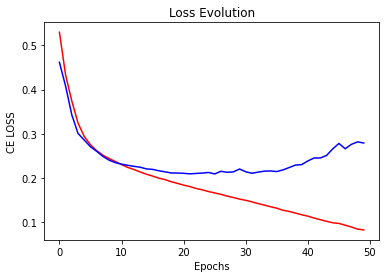

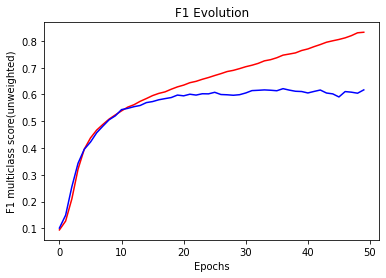

In [30]:
#Plot accuracy
#NB: my accuracy is "drogata" dalla presenza del padding 
#Padding elements are classified as 0,  class 0 is then more populated and because is accuracy is always above 0.9 tha final accuracy results more high then reality
#In order to check is the model is Overfitting and limit the effect of padding on loss/accuracy results i am using the f_1 results on both train and 
plt.figure()

plt.subplot(111)
plt.title('Loss Evolution')
plt.plot(np.array(loss_history), 'r',np.array(loss_history_val),'b')
plt.ylabel('CE LOSS')
plt.xlabel('Epochs')
plt.show()



plt.subplot(111)
plt.title('F1 Evolution')
plt.plot(np.array(f1_history), 'r',np.array(f1_history_val),'b')
plt.ylabel('F1 multiclass score(unweighted)')
plt.xlabel('Epochs')
plt.show()

## Confusion Matrix

<AxesSubplot:>

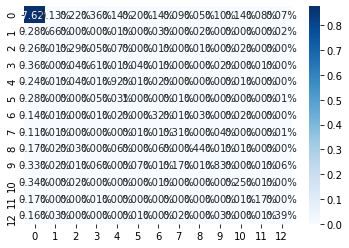

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


cf_matrix = confusion_matrix(total_labels_val, total_prediction_val)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')